### Day 4 - Naive matmul+exercises

In [57]:
import numpy as np
from PIL import Image

In [58]:
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
cuda.init()

device = cuda.Device(0)

print(f"Cuda version: {".".join([str(i) for i in cuda.get_version()])}")
print(f"Device:\t{device.name()}")

Cuda version: 12.8.0
Device:	NVIDIA GeForce RTX 3080 Laptop GPU


In [59]:
from pathlib import Path

In [60]:
cu_file = "kernels/matmul/matmul.cu"

In [61]:
#|output: asis
#|echo: false

c_code = Path(cu_file).read_text()
print(f'''
### Naive matmul [{cu_file}](https://github.com/xl0/cuda-100/blob/master/nbs/{cu_file})

::: {{.sourceCode}}
```cpp
{c_code}
```
:::
''')


### Naive matmul [kernels/matmul/matmul.cu](https://github.com/xl0/cuda-100/blob/master/nbs/kernels/matmul/matmul.cu)

::: {.sourceCode}
```cpp
#include <stdint.h>
#include <stdio.h>

__global__ void matmul_f32(float *m1, float *m2, float *res,
    uint32_t out_shape_0,
    uint32_t out_shape_1,
    uint32_t inner_dim,
    uint32_t ) {

    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    int m1_width = inner_dim;
    int m2_width = out_shape_1;

    double out;
    if (x < out_shape_1 && y < out_shape_0) {
        out = 0;
        for (int i = 0; i < inner_dim; i++) {
            out += m1[y*m1_width + i] * m2[i*m2_width + x];
        }
        res[y*out_shape_1 + x] = out;
    }
}



```
:::



In [62]:
from lovely_numpy import Lo

In [63]:
m1 = np.random.randn(100, 200).astype(np.float32)
m2 = np.random.randn(200, 300).astype(np.float32)

np_res = np.matmul(m1, m2)
Lo(np_res)

array[100, 300] f32 n=30000 (0.1Mb) x∈[-57.284, 65.644] μ=-0.102 σ=14.150

### Testing naive matnul

In [64]:
BLOCK_SIZE_X = 32
BLOCK_SIZE_Y = 32

assert(len(m1.shape) == 2)
assert(len(m2.shape) == 2)
assert(m1.shape[1] == m2.shape[0])

out_shape = (m1.shape[0], m2.shape[1])

try:
    ctx = device.make_context()

    mod = SourceModule(Path(cu_file).read_text(),
        options=[
            '-Xcompiler', '-Wall',
            '-Xcompiler', '-Wextra',
            '-Xcompiler', '-Wsign-conversion',
            '-Xcompiler', '-Wcast-qual',
            '-Xcompiler', '-Wunused-parameter',
            '-Xcompiler', '-Wdouble-promotion',
            '-Xcompiler', '-Wformat=2',
            '-Xcompiler', '-Wfloat-equal',
            '-Xcompiler', '-Wshadow'
        ]
        )

    matmul_f32 = mod.get_function("matmul_f32")

    gpu_m1 = cuda.mem_alloc_like(m1)
    gpu_m2 = cuda.mem_alloc_like(m2)

    res = np.empty(out_shape, dtype=np.float32)

    gpu_res = cuda.mem_alloc_like(res)


    cuda.memcpy_htod(gpu_m1, m1)
    cuda.memcpy_htod(gpu_m2, m2)

    block_size = (BLOCK_SIZE_X, BLOCK_SIZE_Y, 1)
    grid_size = (
        ((out_shape[1] + BLOCK_SIZE_X - 1) // BLOCK_SIZE_X),
        ((out_shape[0] + BLOCK_SIZE_Y - 1) // BLOCK_SIZE_Y),
        1
    )

    print(f"Grid size: {grid_size}")
    print(f"Block size: {block_size}")
    print(f"Restul dimensions: {out_shape[0]}x{out_shape[1]}")
    print(f"Total threads: {grid_size[0] * grid_size[1] * block_size[0] * block_size[1]}")

    ctx.synchronize()

    matmul_f32(gpu_m1, gpu_m2, gpu_res, np.uint32(out_shape[0]), np.uint32(out_shape[1]), np.uint32(m1.shape[1]), grid=grid_size, block=block_size)

    ctx.synchronize()

    cuda.memcpy_dtoh(res, gpu_res)
    ctx.synchronize()


finally:
    ctx.pop()
    ctx.detach()

Lo(res)

Grid size: (10, 4, 1)
Block size: (32, 32, 1)
Restul dimensions: 100x300
Total threads: 40960


array[100, 300] f32 n=30000 (0.1Mb) x∈[-57.284, 65.644] μ=-0.102 σ=14.150

In [65]:
m1[0,1],m2[1,0]

(np.float32(-0.9388011), np.float32(0.16297509))

In [66]:
np.isclose(res, np_res).all()

np.False_

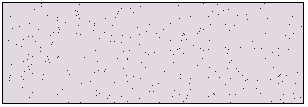

In [67]:
Lo(np.isclose(res, np_res)).chans

### Nunmeric stability
Looks like matmul is very succeptible to numerical instability.
> Since we are adding numbers to the accumulator over and over, if the accumulated value gets large enough,
> it will lose precision to correctly accumulate small values. If it then gets a large update opposite of accumulated value
> and becomes small again, those errors will become very significant.

But I think overall it's correct. I changed to accumulator to be double, and still seeting the discrepancy. It's possible
that numpy matmul also not not very precise.

### Exercises

Let's do the exercises

1. In this chapter we implemented a matrix multiplication kernel that has each thread produce one output matrix element. In this question, you will implement different matrix-matrix multiplication kernels and compare them.
    - a. Write a kernel that has each thread produce one output matrix row. Fill in the execution configuration parameters for the design.
    - b. Write a kernel that has each thread produce one output matrix column. Fill in the execution configuration parameters for the design.
    - c. Analyze the pros and cons of each of the two kernel designs.

In [68]:
cu_file2 = "kernels/matmul/matmul-row_col.cu"

One thread per row/col:

In [69]:
#|output: asis
#|echo: false

c_code = Path(cu_file2).read_text()
print(f'''
### Naive matmul row/col [{cu_file2}](https://github.com/xl0/cuda-100/blob/master/nbs/{cu_file2})

::: {{.SourceCode}}
```cpp
{c_code}
```
:::
''')


### Naive matmul row/col [kernels/matmul/matmul-row_col.cu](https://github.com/xl0/cuda-100/blob/master/nbs/kernels/matmul/matmul-row_col.cu)

::: {.SourceCode}
```cpp
#include <stdint.h>
#include <stdio.h>

__global__ void matmul_f32(float* m1, float* m2, float* res,
                           uint32_t out_shape_0,
                           uint32_t out_shape_1,
                           uint32_t inner_dim)
{

    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    int m1_width = inner_dim;
    int m2_width = out_shape_1;

    double out;
    if (x < out_shape_1 && y < out_shape_0) {
        out = 0;
        for (int i = 0; i < inner_dim; i++) {
            out += m1[y * m1_width + i] * m2[i * m2_width + x];
        }
        res[y * out_shape_1 + x] = out;
    }
}

__global__ void matmul_f32_row(float* m1, float* m2, float* res,
                               uint32_t out_shape_0,
                               uint32_t out_shape_

### Testing the thread per row matmul

In [70]:
BLOCK_SIZE_X = 1
BLOCK_SIZE_Y = 32

assert(len(m1.shape) == 2)
assert(len(m2.shape) == 2)
assert(m1.shape[1] == m2.shape[0])

out_shape = (m1.shape[0], m2.shape[1])

try:
    ctx = device.make_context()

    mod = SourceModule(Path(cu_file2).read_text(),
        options=[
            '-Xcompiler', '-Wall',
            '-Xcompiler', '-Wextra',
            '-Xcompiler', '-Wsign-conversion',
            '-Xcompiler', '-Wcast-qual',
            '-Xcompiler', '-Wunused-parameter',
            '-Xcompiler', '-Wdouble-promotion',
            '-Xcompiler', '-Wformat=2',
            '-Xcompiler', '-Wfloat-equal',
            '-Xcompiler', '-Wshadow'
        ]
        )

    matmul_f32_row = mod.get_function("matmul_f32_row")

    gpu_m1 = cuda.mem_alloc_like(m1)
    gpu_m2 = cuda.mem_alloc_like(m2)

    res_row = np.empty(out_shape, dtype=np.float32)

    gpu_res_row = cuda.mem_alloc_like(res_row)


    cuda.memcpy_htod(gpu_m1, m1)
    cuda.memcpy_htod(gpu_m2, m2)

    block_size = (BLOCK_SIZE_X, BLOCK_SIZE_Y, 1)
    grid_size = (1, ((out_shape[0] + BLOCK_SIZE_Y - 1) // BLOCK_SIZE_Y), 1)

    print(f"Grid size: {grid_size}")
    print(f"Block size: {block_size}")
    print(f"Restul dimensions: {out_shape[0]}x{out_shape[1]}")
    print(f"Total threads: {grid_size[0] * grid_size[1] * block_size[0] * block_size[1]}")

    ctx.synchronize()

    matmul_f32_row(gpu_m1, gpu_m2, gpu_res_row, np.uint32(out_shape[0]), np.uint32(out_shape[1]), np.uint32(m1.shape[1]), grid=grid_size, block=block_size)
    # ctx.synchronize()

    cuda.memcpy_dtoh(res_row, gpu_res_row)
    ctx.synchronize()


finally:
    ctx.pop()
    ctx.detach()

Lo(res_row)

Grid size: (1, 4, 1)
Block size: (1, 32, 1)
Restul dimensions: 100x300
Total threads: 128


array[100, 300] f32 n=30000 (0.1Mb) x∈[-57.284, 65.644] μ=-0.102 σ=14.150

In [71]:
Lo(res)

array[100, 300] f32 n=30000 (0.1Mb) x∈[-57.284, 65.644] μ=-0.102 σ=14.150

In [72]:
(res == res_row).all()

np.True_

### Testing one thread per col matnul

In [73]:
BLOCK_SIZE_X = 32
BLOCK_SIZE_Y = 1

assert(len(m1.shape) == 2)
assert(len(m2.shape) == 2)
assert(m1.shape[1] == m2.shape[0])

out_shape = (m1.shape[0], m2.shape[1])

try:
    ctx = device.make_context()

    mod = SourceModule(Path(cu_file2).read_text(),
        options=[
            '-Xcompiler', '-Wall',
            '-Xcompiler', '-Wextra',
            '-Xcompiler', '-Wsign-conversion',
            '-Xcompiler', '-Wcast-qual',
            '-Xcompiler', '-Wunused-parameter',
            '-Xcompiler', '-Wdouble-promotion',
            '-Xcompiler', '-Wformat=2',
            '-Xcompiler', '-Wfloat-equal',
            '-Xcompiler', '-Wshadow'
        ]
        )

    matmul_f32_col = mod.get_function("matmul_f32_col")

    gpu_m1 = cuda.mem_alloc_like(m1)
    gpu_m2 = cuda.mem_alloc_like(m2)

    res_col = np.empty(out_shape, dtype=np.float32)

    gpu_res_col = cuda.mem_alloc_like(res_col)


    cuda.memcpy_htod(gpu_m1, m1)
    cuda.memcpy_htod(gpu_m2, m2)

    block_size = (BLOCK_SIZE_X, BLOCK_SIZE_Y, 1)
    grid_size = (((out_shape[1] + BLOCK_SIZE_X - 1) // BLOCK_SIZE_X),1,1)

    print(f"Grid size: {grid_size}")
    print(f"Block size: {block_size}")
    print(f"Restul dimensions: {out_shape[0]}x{out_shape[1]}")
    print(f"Total threads: {grid_size[0] * grid_size[1] * block_size[0] * block_size[1]}")

    ctx.synchronize()

    matmul_f32_col(gpu_m1, gpu_m2, gpu_res_col, np.uint32(out_shape[0]), np.uint32(out_shape[1]), np.uint32(m1.shape[1]), grid=grid_size, block=block_size)
    ctx.synchronize()

    cuda.memcpy_dtoh(res_col, gpu_res_col)
    ctx.synchronize()


finally:
    ctx.pop()
    ctx.detach()

Lo(res_col)

Grid size: (10, 1, 1)
Block size: (32, 1, 1)
Restul dimensions: 100x300
Total threads: 320


array[100, 300] f32 n=30000 (0.1Mb) x∈[-57.284, 65.644] μ=-0.102 σ=14.150

In [74]:
(res_col == res).all()

np.True_

-  c. Analyze the pros and cons of each of the two kernel designs.
```
They both suck, but because we are not using enough threads to saturate the GPU.
Row possibly sucks less because the cache is shared between thread blocks.
```